In [48]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats


sns.set_style("whitegrid")
sns.set(font='serif')
sns.set_style("white", {
  "font.family": "serif",
  "font.serif": ["Times", "Palatino", "serif"],
})

FILENAME = 'output'

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(df):
    unique_models = df['model'].unique()
    num_models = len(unique_models)

    fig, axes = plt.subplots(1, num_models, figsize=(11 * num_models, 10))

    # Ensure axes is iterable even for one model
    if num_models == 1:
        axes = [axes]

    x_min = 0.88
    x_max = 0.92

    for i, model_name in enumerate(unique_models):
        model_results = df[df['model'] == model_name]
        ax = sns.pointplot(
            data=model_results,
            x='f1-score(weighted avg)',
            y='Severity',
            hue='strategy',
            linestyles='none',
            errorbar="ci",
            dodge=.7,
            err_kws={'linewidth': 3},
            ax=axes[i]
        )

        ax.set_xlabel("F1-Score", fontsize=42)
        ax.set_xlim(x_min, x_max)

        if i == 0:
            ax.set_ylabel("Severity", fontsize=42)
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=1.5, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=2.5, color='grey', linestyle='--', linewidth=1)
        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=24)
        ax.set_title(model_name, fontsize=42)

        # Remove the first and last x ticks
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks[1:-1])

    # Remove legends from individual subplots
    for ax in axes:
        ax.legend_.remove()

    # Add a single legend for the figure
    handles, labels = ax.get_legend_handles_labels()
    for handle in handles:
        handle.set_marker('o')
        handle.set_markersize(30)

    fig.legend(
        handles, labels, title="Strategy", loc='lower center',
        bbox_to_anchor=(0.5, -0.42), fontsize=42, title_fontsize=42, ncol=3
    )
    fig.suptitle('Distributions Domain Range', fontsize=50, y=1)
    plt.tight_layout()
    plt.savefig('../output/results_ci_each_domain.pdf', bbox_inches='tight')
    plt.show()

In [50]:
results = pd.read_csv(f'../output/{FILENAME}.csv')
# results['evaluation_set'] = results['evaluation_set'].str.replace(' 3', '')
results['Severity'] = 'In-Distribution'

# Out of Distribution Stratified by Corruption Type


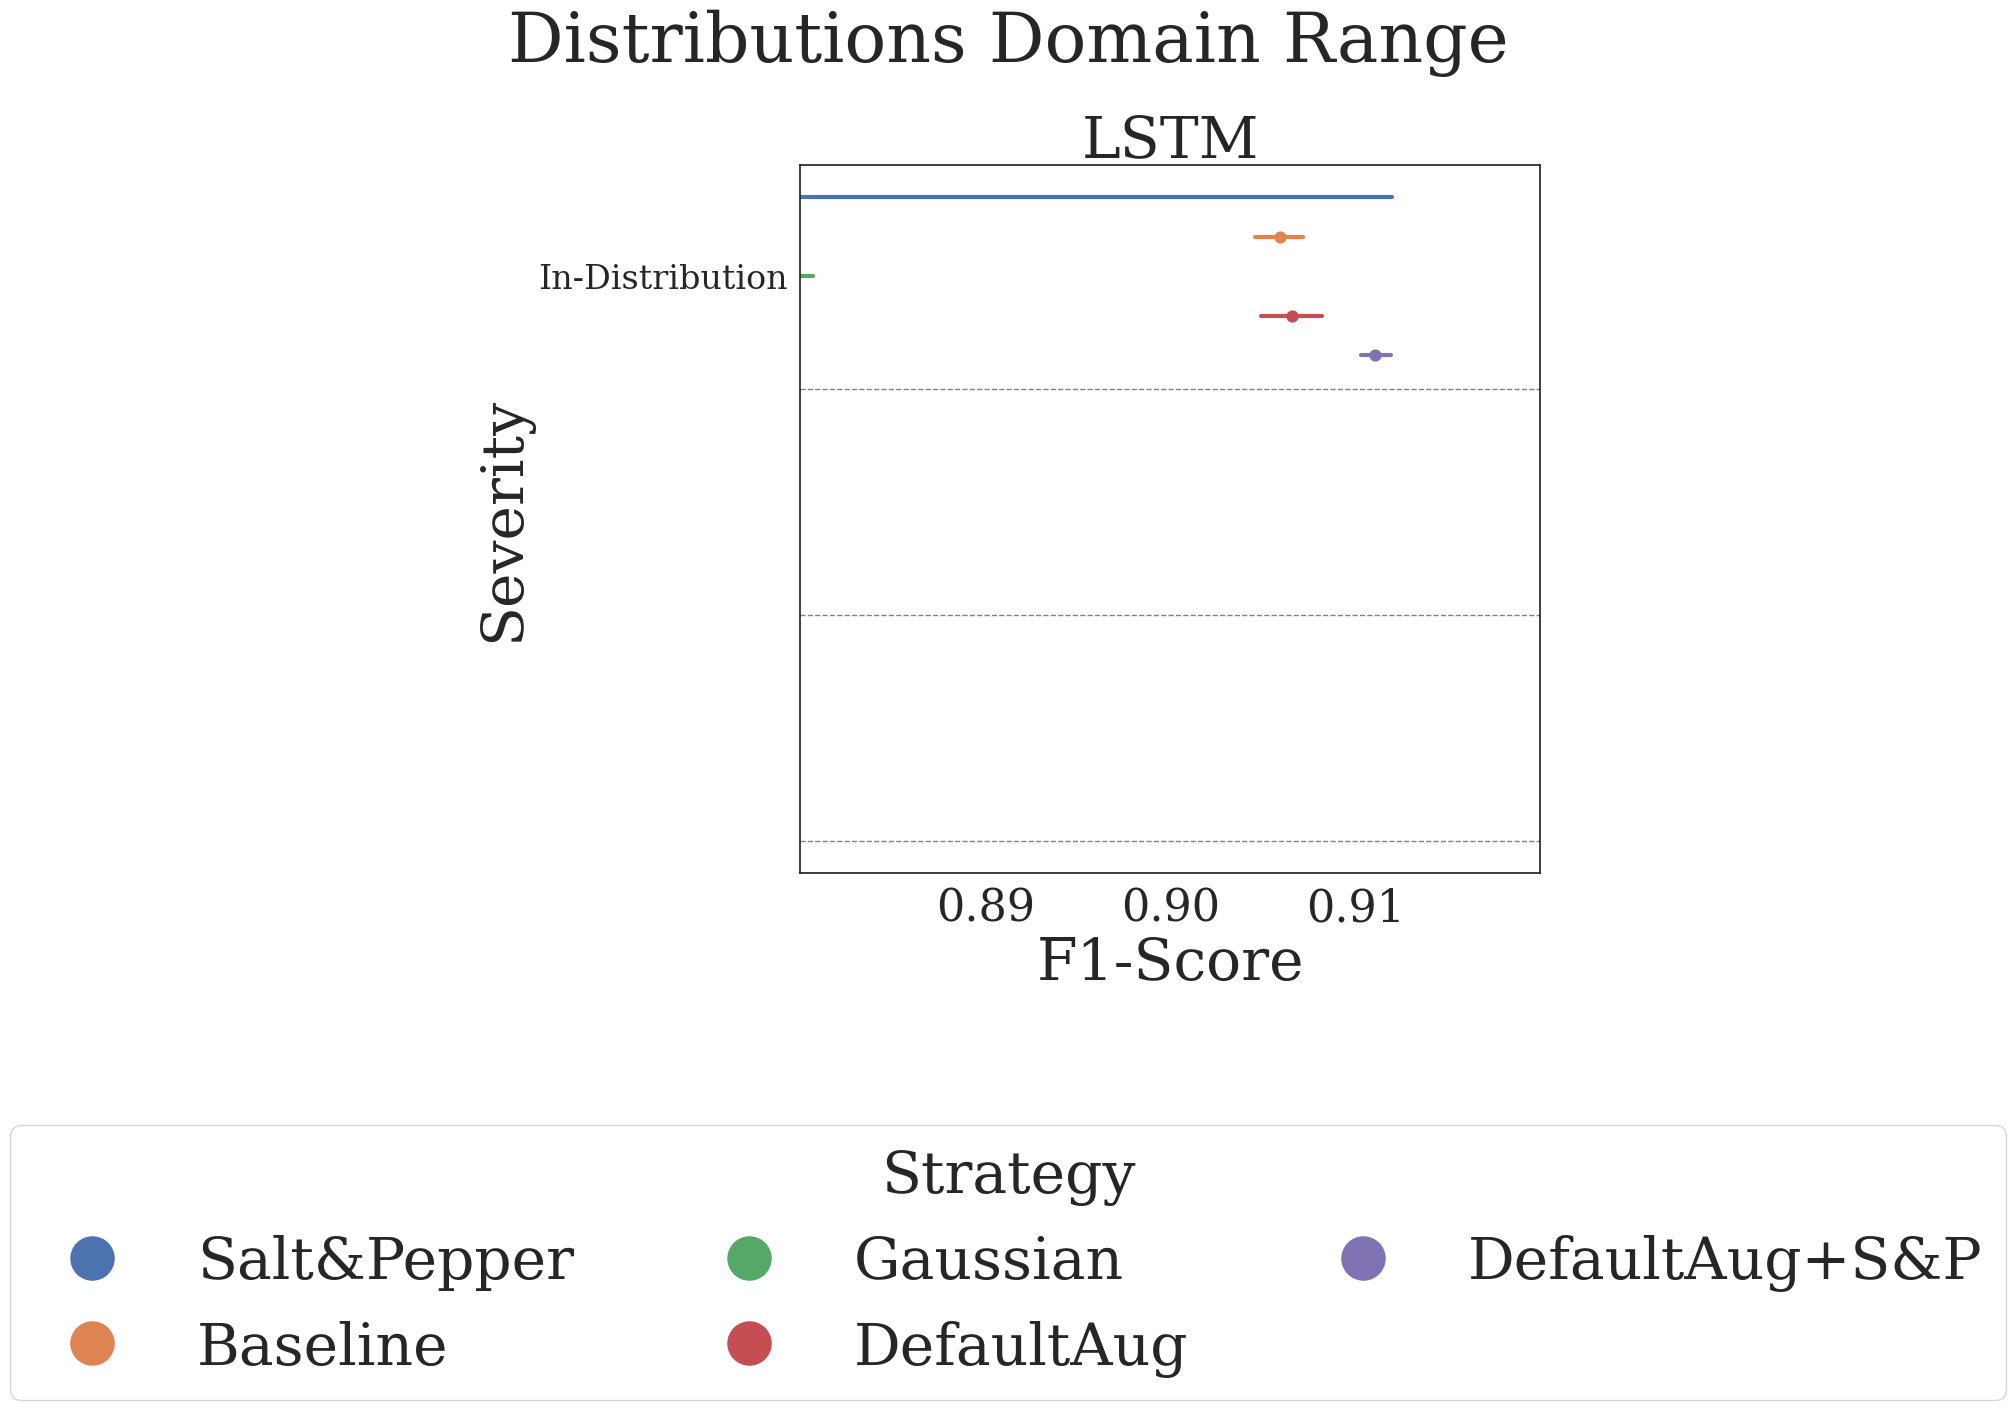

In [51]:
plot_results(results)

In [52]:
def bootstrap_confidence_interval(data, num_samples=1000, ci=0.95):
    data = np.array(data)

    res = stats.bootstrap((data,), np.mean, confidence_level=ci, n_resamples=num_samples, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

In [53]:
grouped = results.groupby(['model', 'strategy', 'Severity'])
confidence_intervals = grouped['f1-score(weighted avg)'].apply(lambda x: bootstrap_confidence_interval(x.values))
average_fscore = grouped['f1-score(weighted avg)'].mean()

confidence_intervals_df = pd.DataFrame({
    'Model': confidence_intervals.index.get_level_values('model'),
    'strategy': confidence_intervals.index.get_level_values('strategy'),
    'Severity': confidence_intervals.index.get_level_values('Severity'),
    'F-Score 95%': [f"{avg:.4f} ({lower:.4f}, {upper:.4f})" for (avg, (lower, upper)) in zip(average_fscore, confidence_intervals)]
})

confidence_intervals_df

,Model,strategy,Severity,F-Score 95%
0,LSTM,Baseline,In-Distribution,"0.9059 (0.9048, 0.9074)"
1,LSTM,DefaultAug,In-Distribution,"0.9066 (0.9050, 0.9083)"
2,LSTM,DefaultAug+S&P,In-Distribution,"0.9111 (0.9101, 0.9119)"
3,LSTM,Gaussian,In-Distribution,"0.8016 (0.7226, 0.9575)"
4,LSTM,Salt&Pepper,In-Distribution,"0.8301 (0.7482, 0.9924)"
